# テキストデータの処理

データの性質を示す特徴量

- 量を表現する連続値特徴量

- 決めたれたリストの中のアイテムを示すカテゴリ特徴量

- テキスト 🆕

# 文字列として表現されているデータのタイプ

文字列データの種類

- カテゴリデータ

- 意味的にはカテゴリに分類できる自由に書かれた文字列

- 構造化された文字列

- テキストデータ

## テキスト解析の用語

- データセット...

    コーパス(corpus)

- 一つのテキストとして表現される個々のデータポイント...

    文書(document)

In [1]:
# 映画レビューのセンチメント分析をする
# データのダウンロードはREADMEより
!tree -dL 2 data/aclImdb
# IPythonでは!lsのように先頭に!をつけることでシステムコマンド（OSコマンド / シェルコマンド）を実行できる。
# https://note.nkmk.me/jupyter-notebook-system-command/

data/aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    └── pos

6 directories


In [2]:
# unsupはいらないから消しておく
!rm -r data/aclImdb/train/unsup

rm: data/aclImdb/train/unsup: No such file or directory


In [3]:
# ラベルがサブフォルダに対応するフォルダ構造からデータを読み込むための関数がある
from sklearn.datasets import load_files

reviews_train = load_files("data/aclImdb/train/")
# load_filesは一連の訓練テキストと訓練ラベルを返す
text_train, y_train = reviews_train.data, reviews_train.target
print(f"Type of txst_train: {type(text_train)}")
print(f"length of text_train: {len(text_train)}")
print(f"text_train[1]:\n{text_train[1]}")

Type of txst_train: <class 'list'>
length of text_train: 25000
text_train[1]:
b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decisio

In [4]:
# レビューにHTMLの改行シーケンスがあることがあるから、取り除いておく
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]
# テキストはbyte型になっている→b""となっている
# https://www.kannon.link/fuku/index.php/2017/02/22/01-34/
# https://techacademy.jp/magazine/18885

In [5]:
# 肯定的なクラスと否定的なクラスがバランスするように集められている

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

print(f"Sample per class (training): {np.bincount(y_train)}")

Sample per class (training): [12500 12500]


In [6]:
# テストセットもロード
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print(f"Number of documents in test data: {len(text_test)}")
print(f"Samples per class (test): {np.bincount(y_test)}")
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


#  Bag of Wordsによるテキスト表現

章立て、パラグラフ、文章、フォーマットなどの文章の持つ構造を捨てて、コーパスに現れた単語がテキストに現れる回数だけが数えられる。
単語の現れる回数だけを数えるから、テキストを単語を入れる袋(bag)として考えている。

文章の表現であるコーパスに対してBoW表現を計算するステップ

1. トークン分割(tokenization)

    個々の文章を単語(トークン)に分割

1. ボキャブラリ構築(vocabulary building)

    全ての文書に現れる全ての単語をボキャブラリとして集め、番号をつける(例えばアルファベット順で)

1. エンコード

    個々の文書に対してボキャブラリの現れる回数を数える

詳しくはP.322

In [7]:
#  トイデータでBoWを試してみる。変換器としてCountVectorizerに実装されている
bards_words = ["The fool doth think he is wise,", "but the wise man knows himself to be a fool"]

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [9]:
# CountVectorizerのfitでは、訓練データのトークン分割とボキャブラリ構築が行われる。
# ボキャブラリはvocabulary_属性で確認できる
print(f"Vocabulary size: {len(vect.vocabulary_)}")
print(f"Vocabulary content:\n{vect.vocabulary_}")

Vocabulary size: 13
Vocabulary content:
{'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [10]:
# BoW表現を作るには、transformメソッドを呼び出す
bag_of_words = vect.transform(bards_words)
print(f"bag_of_words: {repr(bag_of_words)}")
# repr: objectをeval()で再び元のオブジェクトに戻せる文字列に変換して返す。representationの略。
# https://gammasoft.jp/blog/use-diffence-str-and-repr-python/

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


結果の詳しい説明はP.324へ

2行13列の行列で、2つのデータポイントに対して行が割り当てられる。

BoW表現は、SciPyの疎行列として格納されている。ほとんどの文書にはボキャブラリ中の単語のごく一部しか現れず、特徴量に対する要素のほとんどが0になるため。(メモリを節約できる)

疎行列の内容をみるには、toarrayメソッドを用いて「密な」NumPy行列に変換すればいい。

In [11]:
print(f"Dense representation of bag_of_words:\n{bag_of_words.toarray()}")
# 4番目のfool、10番目のthe、13番目のwiseが両方の文字列に出現している

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


In [12]:
# 映画レビューのタスクにBoWを適用してみる
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train:\n{repr(X_train)}")
# ボキャブラリは74849単語で構成されている

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [13]:
# ボキャブラリにアクセスする方法として、CountVectorizerのget_feature_nameである。個々の特徴量に対応するエントリのリストを返す
feature_names = vect.get_feature_names()
print(f"Number of features: {len(feature_names)}")
print(f"First 20 features:\n{feature_names[:20]}")
print(f"Features 20010 to 20030:\n{feature_names[20010:20030]}")
print(f"Every 2000th features:\n{feature_names[::2000]}")

Number of features: 74849
First 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th features:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [14]:
# 特徴量抽出を改良する前に、クラス分類器を実際に構築してみる
# 高次元の疎なデータに対しては、LogisticRegressionのような線形モデルが有効
# 交差検証を用いて評価してみる。デフォルトでは統計量を集めたりしないから、パイプラインを使わなくてもおk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import time

start = time.time()
scores = cross_val_score(LogisticRegression(solver='liblinear'), X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores):.2f}")

process_time = time.time() - start
print(f"exec time (n_jobs=None): {process_time:.3f}")

Mean cross-validation accuracy: 0.88
exec time (n_jobs=None): 32.178


In [15]:
start = time.time()
scores = cross_val_score(LogisticRegression(solver='liblinear'), X_train, y_train, cv=5, n_jobs=-1)
print(f"Mean cross-validation accuracy: {np.mean(scores):.2f}")

process_time = time.time() - start
print(f"exec time (n_jobs=-1): {process_time:.3f}")

Mean cross-validation accuracy: 0.88
exec time (n_jobs=-1): 15.025


In [16]:
# LogregパラメータCをチューニングしてみる
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Best parameters:\n{grid.best_params_}")

Best cross-validation score: 0.89
Best parameters:
{'C': 0.1}


In [17]:
X_test = vect.transform(text_test)
print(f"{grid.score(X_test, y_test):.2f}")

0.88


In [18]:
# 数字のような情報量のない特徴量を得ないようにする対策として、2つ以上の文書に登場しているトークンだけを用いるようにすること。
# トークンとして採用されるために現れるべき単語数をmin_dfパラメータで設定できる
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train with min_df: {repr(X_train)}")
# 5つ以上の文書に現れたものだけをトークンとすることで、74,849→27,271まで特徴量を減らせた。

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [19]:
feature_names = vect.get_feature_names()

print(f"First 20 features:\n{feature_names[:20]}")
print(f"Features 20010 to 20030:\n{feature_names[20010:20030]}")
print(f"Every 2000th features:\n{feature_names[::700]}")

First 20 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 2000th features:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciation', 'recipient', 'reviews', 'sas', 'shea', 'sneers', 'steiger', 'swastika', 'thrusting', 'tvs', 'vampyre', 'westerns']


In [20]:
# グリッドサーチをしてみる
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")

Best cross-validation score: 0.89


訓練データ中にない単語を含んだ文書に対してCOuntVectorizerのtransformメソッドを呼び出すと、訓練データ中にない単語はディクショナリに含まれないから無視される。クラス分類においてはこれは問題にならない。訓練データにない単語についてはいずれにしろ何も学習できないから。 

P.329

# ストップワード

役に立たない単語を取り除くもう一つの方法。頻出しすぎるため役に立たない単語を捨てる方法。

- 言語固有のストップワードリストを作っておく方法

- 頻度の高い単語を捨てる方法

scikit-learnには英語のストップワードリストをfeature_extraction.textモジュールに用意している

In [21]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(f"Number of stop words: {len(ENGLISH_STOP_WORDS)}")
print(f"Every 10th stopword:\n{list(ENGLISH_STOP_WORDS)[::10]}")

Number of stop words: 318
Every 10th stopword:
['been', 'former', 'six', 'an', 'third', 'anyone', 'she', 'fire', 'against', 'rather', 'wherein', 'next', 'toward', 'else', 'about', 'something', 'its', 'might', 'eg', 'whatever', 'name', 'sincere', 'mine', 'per', 'alone', 'during', 'his', 'out', 'describe', 'or', 'before', 'hundred']


In [22]:
# ストップワードを使って学習してみる
# stop_words="english"を指定すると、組み込みのストップワードリストを用いる
# ストップワードリストに単語を追加したり、独自のものを使うこともできる
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train with stop words:\n{repr(X_train)}")
# 305(27271-26966)減っている。ストップワードのほとんどがデータセットに現れていた。

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [23]:
# グリッドサーチを実行する
grid = GridSearchCV(LogisticRegression(solver="liblinear"), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")
# ストップワードを用いた効果はあまりないが、小さいデータセットに対しては有効

Best cross-validation score: 0.88


頻出する単語を捨てる方法を自分で試してみる。max_dfオプションを用いる

# tf-idf(term frequency-inverse document frequency)を用いたデータのスケール変換

重要そうでない特徴量を落とすのではなく、特徴量がどの程度情報を持っていそうかに応じて、特徴量のスケールを変換する手法。

特定の文書にだけ頻繁に現れる単語に大きな重みを与え、コーパス中の多数の文書に現れる単語にはあまり重みを与えない。特定の文書にだけ頻出し、他の文書にはあまり現れない単語は、その文書の内容をよくあらわしているのではないか、という発想。

scikit-learnではtf-idfを2つのクラスで実装している。TfidfTransformerはCountVectorizerの生成する疎行列を入力とする。

TfidfVectorizerはテキストデータを入力とし、BoW特徴量抽出とtf-idf変換を行う。tf-idfスケールには様々な方法がある→P.330

tf-idfは訓練データの統計的性質を利用するため、パイプラインを用いてグリッドサーチの結果が有効になるようにする。

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(solver='liblinear'))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
# pipe内でBoWとtfidfを同時に実行するため、text_train
grid.fit(text_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")

Best cross-validation score: 0.89


tf-idf変換を行うと性能がすこーしだけよくなる。tf-idfがどの単語が最も重要だと判断したかをみることもできる。tf-idf変換は純粋に教師なしの手法であるため、ここでの重要さは、本来の興味の対象である、肯定的なレビュー・否定的なレビューのラベルに必ずしも関係しない。

In [25]:
# パイプラインからTfidfVectorizerを取り出す
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# 訓練データセットを変換
X_train = vectorizer.transform(text_train)
# それぞれの特徴量のデータセット中での最大値を見つける
max_value = X_train.max(axis=0).toarray().ravel()
sorted_byidf = max_value.argsort()
# 特徴量を取得
feature_names = np.array(vectorizer.get_feature_names())

print(f"Features with lowest tfidf:\n{feature_names[sorted_byidf[:20]]}")

print(f"Features with highest tfidf:\n{feature_names[sorted_byidf[-20:]]}")

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf:
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


tf-idfが低い特徴量は、多くのが文書に共通して出現するか、あまり出現しないか、非常に長い文書にしか出現しないか。

tf-idfが高い特徴量の多くは、特定の映画を指している。映画にまつわる固有単語はセンチメント分析タスクにはあまり役に立たないが、レビューに固有の情報をたくさん含んでいる。

文書頻度の逆数(inverse document frequency:idf)が小さい単語が高い頻度で現れるため、重要でないと考えられる単語。訓練セットに対する文書頻度の逆数はidf_属性に格納される。

In [26]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print(f"Feature with lowest idf:\n{feature_names[sorted_by_idf[:100]]}")

Feature with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


これらのほとんどはストップワードだが、映画のレビューに固有の単語や、'good', 'great', 'bad'などの単語もある。

good badなどはセンチメント分析タスクでは非常に重要だと思われるのにもかかわらず、多くの文書に頻出するため、tf-idfの尺度では「関連性が低い」と判断されている

# モデル係数の調査

訓練したロジスティック回帰モデルが実際にデータから学習したのかを確認する。

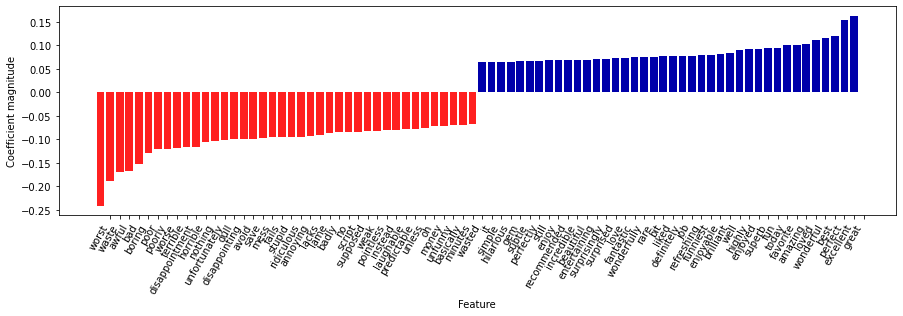

In [27]:
# 係数が最も大きい25の特徴量と最も小さい25の特徴量を示す
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps['logisticregression'].coef_,
    feature_names, n_top_features=40)

# 1単語よりも大きい単位のBag-of-Words(n-グラム) P.334

複数の連続するトークンの列を考えることで、"not good", "not bad"などのコンテクストを捉える。

特徴量と考える列の長さを変更するには、CountVectorizerやTfidfVectorizerのngram_rangeパラメータを設定する。このパラメータはタプルで、特徴量とするトークン列の長さの最小長と最大長を指定する。

In [28]:
# トイデータで試してみる
print(f"bards_words:\n{bards_words}")

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [29]:
# デフォルトでは、特徴量とするトークン列の長さは最小1、最大1となっている。→個々のトークンが特徴量となる(ユニグラム:unigram)
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print(f"Vocabulary size: {len(cv.vocabulary_)}")
print(f"Vocabulary:\n{cv.get_feature_names()}")

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [30]:
# 2つ連続するトークンをみるには、(2, 2)に設定する(バイグラム)
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print(f"Vocabulary size: {len(cv.vocabulary_)}")
print(f"Vocabulary:\n{cv.get_feature_names()}")

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [31]:
# bards_wordsの2つのフレーズには共通したバイグラムがない
print(f"Transformed data (dense):\n{cv.transform(bards_words).toarray()}")

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


ほとんどのアプリケーションでは、トークン列の最小長が1にした方が良い。(1つの単語だけでも相当な意味を持つ場合が多いから)

ほとんどの場合バイグラムを加えると性能が向上する。5-グラムまでは性能向上につながる可能性があるが、特徴量の数が爆発する。

In [32]:
# ユニグラム、バイグラム、トリグラムをbards_wordsに適用
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print(f"Vocabulary size: {len(cv.vocabulary_)}")
print(f"Vocabulary:\n{cv.get_feature_names()}")

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


In [33]:
# グリッドサーチを使ってTfidVectorizerを用いてn-グラムのレンジの最良値を探索する
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
# グリッドが比較的大きい上、トリグラムが含まれるため、実行時間がかなりかかる
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

start_time = time.time()

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(text_train, y_train)

exec_time = time.time() - start_time
print(f"Grid search exec time: {exec_time:.4f}")

print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Best parameters:\n{grid.best_params_}")
# バイグラム・トリグラム特徴量を加えることで、1%以上性能が向上した。

Grid search exec time: 470.0915
Best cross-validation score: 0.91
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


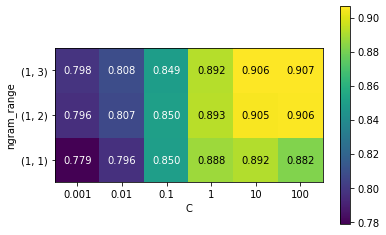

In [34]:
# 交差検証精度をパラメータngram_rangeとCの関数としてヒートマップで表示する
# グリッドサーチのスコアを取り出す(列がngram_rangeになってる?)
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# ヒートマップとして可視化
heatmap = mglearn.tools.heatmap(
    scores, xlabel='C', ylabel='ngram_range', cmap='viridis', fmt='%.3f',
    xticklabels=param_grid['logisticregression__C'], yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)
# バイグラムを追加することで性能かかなり向上するが、トリグラムを追加しても精度の面ではごくわずかな向上しかない。

(-22.0, 22.0)

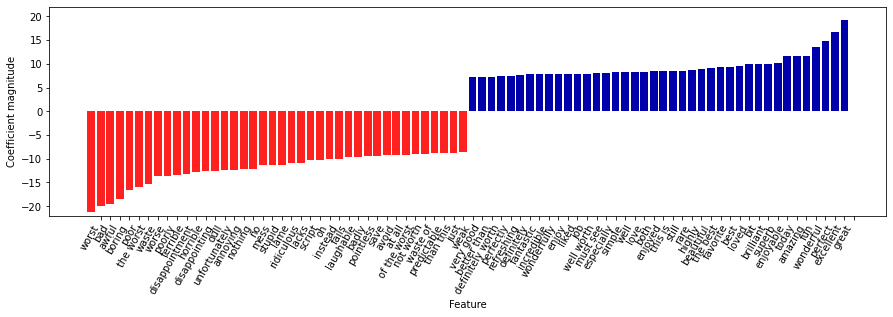

In [35]:
# ユニグラム、バイグラム、トリグラムを含む最良のモデルに対して、重要な係数を可視化してみる
# 特徴量の名前と係数を取り出す
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
plt.ylim(-22, 22)

(-22.0, 22.0)

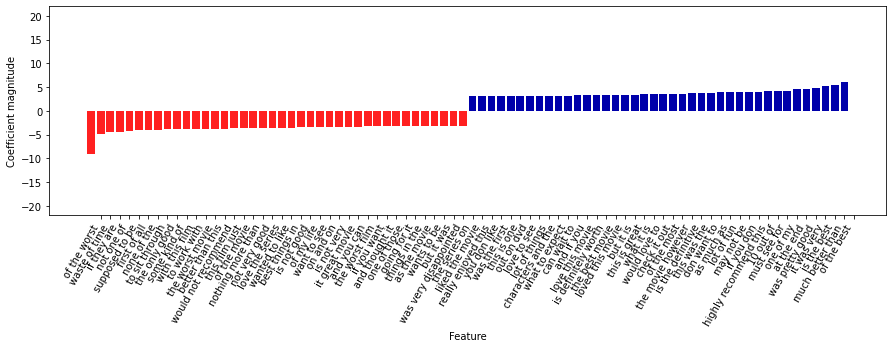

In [36]:
# トリグラムだけ可視化して、トリグラム特徴量が有効な理由を調べてみる。
# ほとんどが"none of the", "of the most"など、単独では有効ではない一般的な単語で構成されている。ユニグラム特徴量と比較すると影響は限定的

# トリグラム特徴量を見つける
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# トリグラム特徴量だけを可視化
mglearn.tools.visualize_coefficients(coef.ravel()[mask], feature_names[mask], n_top_features=40)
plt.ylim(-22, 22)

# より進んだトークン分割、語幹処理、見出語化 P.339

さらなる改良の余地として、BoW構築の最初の過程、トークン分割にある。
同じ単語の単数形や複数形、動詞形や名詞形を一つにまとめること: 語幹(word stem)を使って表現すること。

単語の末尾につく特定の形を取り除くといったようなルールベースの処理を語幹処理(stemming)といい、知られている単語に対して辞書を用いて単語の文章での役割を考慮して行う場合には見出し語化(lemmatization)と呼び、単語の標準的な形を見出語(lemma)と呼ぶ。語幹処理・見出語化はいずれも単語の正規形を取り出す正規化(normalization)である。他にも、スペルミスの修正などもある。

語幹処理と見出語化を比較してみる。語幹処理には広く用いられているヒューリスティクスの集合である`Porter stemmer`を([nltk](https://www.nltk.org/index.html)パッケージからインポート)、見出語化には[spacy](https://spacy.io/)パッケージのものを用いる

```
-> % pip install spacy
-> % pip install nltk

# 英語モデルをインストール
-> % python -m spacy download en_core_web_sm

You can now load the model via spacy.load('en_core_web_sm')
```

In [40]:
import nltk
import spacy

# spacyの英語モデルをロード
en_nlp = spacy.load('en_core_web_sm')
# nltkのPorter stemmerのインスタンスを作成
stemmer = nltk.stem.PorterStemmer()

# spacyによる見出語化とnltkによる語幹処理を比較する関数を定義
def compare_normalization(doc):
    # spacyで文書をトークン分割
    doc_spacy = en_nlp(doc)
    # spacyで見つけた見出語を表示
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # Porter stemmerで見つけたトークンを表示
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [43]:
# 見出語化と語幹処理の違いがわかるように作り込んだ文章を作ってみる u''はユニコード文字列
compare_normalization(u"Our meeting today was worse than yesterday, "
                       "I'm scared of meeting the clients tomorrow.")
# 見出語化は語幹処理よりも複雑な処理で、より良い結果となる。

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


In [47]:
# *1 後方互換性のため、re.U フラグ (と同義の re.UNICODE および埋め込みで使用する (?u)) はまだ存在しますが、Python 3 では文字列のマッチがデフォルトで Unicode (そしてバイト列では Unicode マッチングが扱えない) なので冗長です。
# https://docs.python.org/ja/3/library/re.html

# scikit-learnにはどちらの正規化手法も実装されていないが、CountVectorizerのtokenizerパラメータで、文書をトークン列に変換するトークン分割器を指定することができる。
# spacyの見出語化機能を使って、文字列から見出語の列を作る関数を作って指定すれば良い

# 技術的詳細: CountVectorizerが用いている正規表現ベースのトークン分割器を用いて、見出語化だけにspacyを用いるのが望ましい。
# このため、en_nlp.tokenizer(spacyのトークン分割器)を、正規表現ベースのトークン分割器に置き換えている。
import re
# Countvectorizerで用いられているトークン分割ようの正規表現
# regexp used in Countvectorizer
regexp = re.compile('\\b\\w\\w+\\b') #*1

# spacyの言語モデルを読み込み、トークン分割器を取り出す
en_nlp = spacy.load('en_core_web_sm')
old_tokenizer = en_nlp.tokenizer
# トークン分割器を先ほどの正規表現で置き換える lambdaで実装されている
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# spacyの文書処理パイプラインを用いてカスタムトークン分割器を作る
# (正規表現を用いたトークン分割器を組み込んである)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma for token in doc_spacy]

# CountVectorizerをカスタムトークン分割器を使って定義する
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

ラムダ式

```python
>>> a = lambda num:  num ** 2
>>> a
<function <lambda> at 0x10d734950>
>>> a(2)
4
>>> a(5)
25
```

In [48]:
# データを変換してボキャブラリのサイズを見てみる

start_time = time.time()

X_train_lemma = lemma_vect.fit_transform(text_train)
print(f"X_train_lemma.shape: {X_train_lemma.shape}")

exec_time1 = time.time() - start_time
print(f"lemma exec time: {exec_time1:.3f}")

# 比較のため標準のCountVectorizerでも変換
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train.shape: {X_train.shape}")

exec_time2 = time.time() - exec_time1
print(f"standard exec time: {exec_time1:.3f}")

# 見出語化は特定の特徴量を融合するので、ある種の正則化と見れる。→見出語化によって最も性能が向上するのはデータセットが小さい場合。

X_train_lemma.shape: (25000, 21825)
X_train.shape: (25000, 27271)


In [49]:
# StratifiedShuffleSplitを用いて、データの1%だけを訓練データとし、残りをテストデータとして交差検証を行ってみる。
# データの1%だけを訓練セットとして用いてグリッドサーチを行う
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99, train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=cv, n_jobs=-1)
# 標準のCountVectorizerを用いてグリッドサーチを実行 tf-idfは使ってないからパイプライン化しなくでも大丈夫
grid.fit(X_train, y_train)
print(f"Best cross-validation score (standard CountVectorizer): {grid.best_score_:.3f}")
# 見出語化付きでグリッドサーチを実行
grid.fit(X_train_lemma, y_train)
print(f"Best cross-validation score (lemmatization): {grid.best_score_:.3f}")
# 見出語化を行っても性能は若干向上する程度。結果はデータセットによって異なる。

Best cross-validation score (standard CountVectorizer): 0.721
Best cross-validation score (lemmatization): 0.735


# トピックモデリングと文書クラスタリング

テキストデータによく用いられる技術の一つ。通常は教師なし学習で、それぞれの文書に対して1つ以上のトピック(topic)を割り当てるタスクをまとめて呼ぶ言葉。

例: ニュースデータで、ある記事を政治・スポーツ・金融などのトピックに分類できる。

それぞれの文書に1つのトピックが与えられるのであれば、3章でのべたクラスタリングになり、

複数のトピックを持つことができるのであれば、成分分析に関連してくる。学習した個々の成分がトピックとなり、文書表現のそれぞれの成分に対する係数は、その文書が特定のトピックにどの程度関連するかを表現することになる。

多くの場合、「トピックモデリング」というと、LDA(Latent Dirichlet Allocation)と呼ばれる特定の成分分析手法をさす

# LDA: Latent Dirichlet Allocation P.343

同時に現れる頻度の高い単語の集合(トピック)を探す。このトピックはPCAやNMFの成分に近い。

映画レビューのデータセットにLDAを適用してみる。教師なしのテキスト文書モデルでは、一般的な単語が解析に影響を与えすぎないように、一般的な単語を取り除いた方が良いとされる。15%以上の文書に現れる単語を取り除き、それ以外で最もよく現れる10,000単語に限ってBoWモデルを構築する。

In [50]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [53]:
# 10トピックでトピックモデルを作ってみる。NMFと同様に、トピックに順番がないため、数を変更すると全てのトピックが変更される。
# 学習方法としてデフォルトの"online"ではなく、"batch"を用いる。←少し遅いが、結果が良くなる。
# また、max_iterを大きい値に指定している。これもモデルの性能に貢献する。
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0, n_jobs=-1)
# ここではモデルの構築と変換を一度に行う。変換には時間がかかるが、同時に行うことで時間を節約できる
document_topics = lda.fit_transform(X)

In [54]:
# 3章の時で見た成分分析手法と同様に、それぞれの単語のそのトピックに対する重要性を格納したcomponents_属性がある。サイズは(n_components, n_words)
# →それぞれのトピック(行)に、割り当てられた単語の重要度が入っている(列)
lda.components_.shape

(10, 10000)

In [58]:
# それぞれのトピックについて最も重要な単語を見てみる。print_topics関数を使うと、これらの特徴量をきれいに表示してくれる
# それぞれのトピック(components_の行)に対して、特徴量を昇順でソート
# ソートを降順にするために、[:, ::-1]で列を反転(重要な単語順)
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# vectorizerから特徴量を取得
feature_names = np.array(vect.get_feature_names())

In [60]:
# 最初の10トピックを表示
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
performance   director      us            family        war           
role          nothing       book          young         world         
cast          script        real          father        action        
actors        actors        world         old           us            
performances  doesn         point         mother        series        
excellent     seems         may           girl          american      
beautiful     work          own           son           new           
version       interesting   true          years         our           
actor         enough        fact          woman         human         
director      sex           god           show          japanese      


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
acti

In [61]:
# 100トピックでモデルを作ってみる
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch", max_iter=25, random_state=0, n_jobs=-1)
document_topics100 = lda100.fit_transform(X)

In [63]:
# いくつかのトピックを抜粋
topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])

sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names, sorting=sorting, topics_per_chunk=7, n_words=20)
# 今度のトピックは具体的になっているが、解釈が難しい。トピックについて解析を進めるには、重要な単語から得た直感をそのトピックに分類された文書を見て確認しなければならない。
# テキストとは結果が違うため、試しに36に分類されたレビューを見てみる(ライオンキング？)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
welles        star          new           sex           studio        king          al            
noir          wars          york          violence      hollywood     lion          van           
lady          luke          oscar         nudity        star          david         pacino        
citizen       lucas         award         women         mr            new           dick          
kane          trilogy       performance   female        powell        kirk          tracy         
altman        fulci         role          sexual        cast          timon         play          
price         battle        city          male          early         streets       caine         
orson         emperor       academy       porn          shop          spock         beatty        
robert    

In [65]:
# "ライオンキング"トピック36に対する重みでソート
# document_topics100自体は25,000*100(それぞれのトピックに対する重み)のデータ構造
lionking = np.argsort(document_topics100[:, 36])[::-1]
# このトピックを最も重要としている10の文書を表示
for i in lionking[:10]:
    # 最初の2文を表示
    print(b'.'.join(text_train[i].split(b".")[:2]) + b".\n")
    # '間に挿入する文字列'.join([連結したい文字列のリスト]) + 最後に.と改行を入れてる
    # https://note.nkmk.me/python-string-concat/

b'"Cinema is the ultimate pervert art. It doesn\'t give you what you desire; it tells you how to desire.\n'
b"The next-to-last episode aired of the original Star Trek series is an interesting, sometimes melancholy installment that proves the show was still exploring its characters even at this point in the third season; though flawed, 'All Our Yesterdays' has its moments and overall a moody, compelling feel to it. Kirk, Spock, and McCoy beam down to a planet, assuming they are arriving in the nick of time to save or at least give some warning to whatever populace is there, since the planet's sun is due to explode within hours.\n"
b'If you\'ve ever been harassed on the Underground by a Christian who says, "Jesus is the answer. What\'s the question?", then perhaps you should thank God if you\'ve never met a Lacanian.\n'
b"Given its time of release, the story that unravels in 1950 thriller 'Panic in the Streets' was hardly a surprise. The corpse of a mysterious illegal immigrant is found 

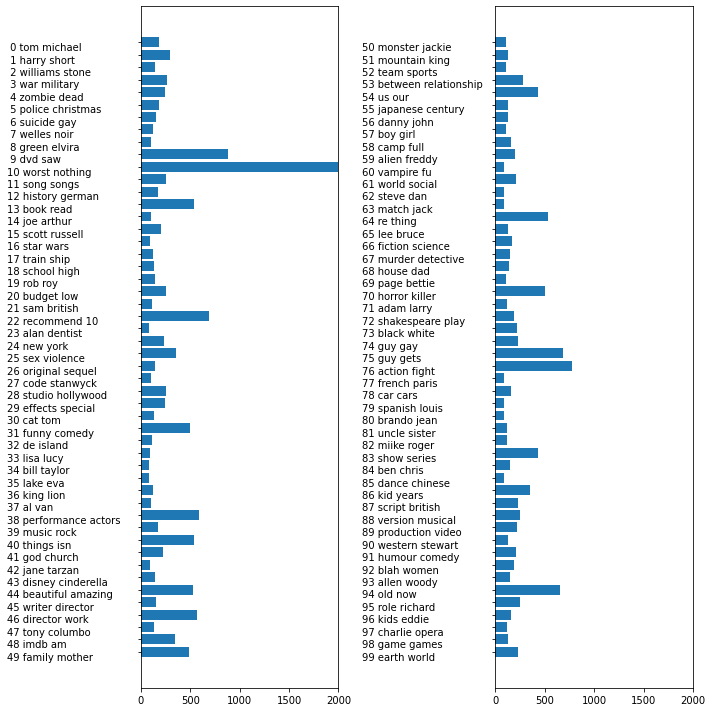

In [68]:
# トピックを調べるもう一つの方法として、それぞれのトピックが全文書に対して得た重みを見てみる。
# それぞれのトピックに、最も一般的な2つの単語で名前をつけている。
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# {:>2}右寄せ   https://note.nkmk.me/python-print-basic/
topic_names = [f"{i:>2} " + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

# 2カラムの棒グラフ
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

LDAは大まかに分けて、ジャンルに固有なトピックと評価に固有なトピック、それ以外の特定しづらいトピックを見つけているように見える。

→多くのレビューは映画固有のコメントと評価を正当化あるいは強調するコメントで構成されている。

LDAのようなトピックモデルは、ラベルがない大規模なテキストコーパスを理解する興味深い方法である。ラベルがある場合にも有用。
特に、transformメソッドで作られたトピック群を教師あり学習のためのコンパクトなデータ表現と見なすこともできる。→ラベルのある訓練データが十分にない場合に有用。

random_stateによって結果が変わる場合がある。

# 今後の展望

自然言語処理の新たな潮流として、リカレントニューラルネットワーク(RNN: recurrent nural network)というのがある。

テキスト処理に適したニューラルネットの一種で、通常のNNモデルによるクラス分類では、テキストからクラスラベルしか生成できないが、RNNはテキストからテキストを生成することができる。→自動翻訳や要約に適している。

詳しくはP.352